In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# 데이터 읽기
raw_data = pd.read_csv('data.csv', encoding='utf-8', engine='python')
raw_data = raw_data.sample(frac=1)
raw_data.head()

,att rate,score,grades
14,11,12,C
13,15,14,C
12,21,26,C
3,89,74,A
4,55,77,A


In [75]:
# 데이터 처리
attendance_rate = raw_data['att rate'].to_numpy(dtype='float64')
print(f'출석률 : {attendance_rate}')

score = raw_data['score'].to_numpy(dtype='float64')
print(f'시험 성적 : {score}')

grade_ = raw_data['grades'].to_numpy()
grade = np.zeros_like(grade_, dtype='int64')

for idx, val in enumerate(grade_):
    """
    one-hot encoding
    A : 2, B : 1, C : 0
    """
    if val == 'A':
        grade[idx] = 2
    elif val == 'B':
        grade[idx] = 1
    else:
        grade[idx] = 0

print(f'학점 : {grade}')


출석률 : [11. 15. 21. 89. 55. 80. 68. 30. 45. 76. 39. 80. 65. 64. 38.]
시험 성적 : [12. 14. 26. 74. 77. 42.  7. 79. 49. 98. 64. 86. 94.  8. 63.]
학점 : [0 0 0 2 2 1 0 1 1 2 1 2 2 0 1]


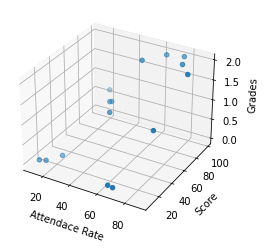

In [76]:
# raw data figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(attendance_rate, score, grade)
ax.set_xlabel('Attendace Rate'); ax.set_ylabel('Score')
ax.set_zlabel('Grades')
plt.show()

In [77]:
# normalization
input_data = raw_data.drop(['grades'], axis=1).to_numpy(dtype='float64')
print(f'정규화 전 데이터 : {input_data}')

input_data -= input_data.mean(axis=0)
input_data /= input_data.std(axis=0)
print(f'정규화 후 데이터 : {input_data}')

print(grade)

정규화 전 데이터 : [[11. 12.]
 [15. 14.]
 [21. 26.]
 [89. 74.]
 [55. 77.]
 [80. 42.]
 [68.  7.]
 [30. 79.]
 [45. 49.]
 [76. 98.]
 [39. 64.]
 [80. 86.]
 [65. 94.]
 [64.  8.]
 [38. 63.]]
정규화 후 데이터 : [[-1.66302992 -1.29587594]
 [-1.49972093 -1.23245623]
 [-1.25475744 -0.85193801]
 [ 1.52149546  0.67013486]
 [ 0.13336901  0.76526442]
 [ 1.15405022 -0.34458039]
 [ 0.66412324 -1.45442519]
 [-0.8873122   0.82868412]
 [-0.27490347 -0.12261143]
 [ 0.99074123  1.4311713 ]
 [-0.51986696  0.35303635]
 [ 1.15405022  1.05065308]
 [ 0.5416415   1.3043319 ]
 [ 0.50081425 -1.42271534]
 [-0.56069421  0.3213265 ]]
[0 0 0 2 2 1 0 1 1 2 1 2 2 0 1]


In [86]:
from keras import models
from keras import layers
import tensorflow as tf

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(10,
        activation='relu',
        input_shape=(input_data.shape[1],)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

# k-fold 
k = 10

num_validation_samples = len(input_data) // k
acc = []
val_acc = []
num_epochs = 500

for i in range(k):
    print(f'처리중인 fold : {i}')
    val_data = input_data[i * num_validation_samples: (i+1) * num_validation_samples]
    val_target = grade[i * num_validation_samples: (i + 1) * num_validation_samples]

    partial_train_data = np.concatenate(
        [input_data[:i*num_validation_samples],
        input_data[(i + 1) * num_validation_samples:]],
        axis=0)
    partial_target_data = np.concatenate(
        [grade[:i*num_validation_samples],
        grade[(i + 1) * num_validation_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_target_data,
                validation_data=(val_data, val_target),
                epochs=num_epochs, batch_size=1)
    acc_ = history.history['accuracy']
    val_acc_ = history.history['val_accuracy']
    acc.append(acc_)
    val_acc.append(val_acc_)
    

처리중인 fold : 0
Epoch 1/500
 1/14 [=>............................] - ETA: 2s - loss: 0.7627 - accuracy: 1.0000

C:\ProgramData\Anaconda3\envs\kaggle\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


14/14 [==============================] - 0s 11ms/step - loss: 1.1674 - accuracy: 0.2143 - val_loss: 0.7024 - val_accuracy: 1.0000
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 1.1347 - accuracy: 0.2143 - val_loss: 0.7120 - val_accuracy: 1.0000
Epoch 3/500
14/14 [==============================] - 0s 6ms/step - loss: 1.1100 - accuracy: 0.2143 - val_loss: 0.7037 - val_accuracy: 1.0000
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 1.0786 - accuracy: 0.2143 - val_loss: 0.6850 - val_accuracy: 1.0000
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 1.0542 - accuracy: 0.3571 - val_loss: 0.6833 - val_accuracy: 1.0000
Epoch 6/500
14/14 [==============================] - 0s 5ms/step - loss: 1.0306 - accuracy: 0.4286 - val_loss: 0.6657 - val_accuracy: 1.0000
Epoch 7/500
14/14 [==============================] - 0s 6ms/step - loss: 1.0123 - accuracy: 0.5000 - val_loss: 0.6417 - val_accuracy: 1.0000
Epoch 8/500
14/14 [=====

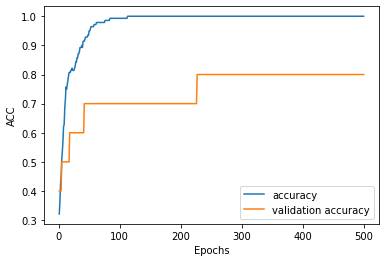

In [87]:
avg_acc_history = [
    np.mean([x[i] for x in acc]) for i in range(num_epochs)
]
avg_val_acc_history = [
    np.mean([x[i] for x in val_acc]) for i in range(num_epochs)
]

x = range(1, len(avg_acc_history)+1)
plt.plot(x, avg_acc_history, label='accuracy')
plt.plot(x, avg_val_acc_history, label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()